### Описание проекта:

**Работа с табличными данными, в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы. Нужно предсказать, какие из них закроются, а какие нет.**

### Цель проекта:

- **Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.** 
- **Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).**

### Исходные данные:

- **kaggle_startups_train_01.csv** - тренировочный набор, содержит информацию (около 53 000 записей) о  стартапах, которые будут использоваться в качестве обучающих данных;
- **kaggle_startups_test_01.csv** - тестовый набор, содержит информацию (около 13 000 записей) о стартапах, которые будут использоваться в качестве тестовых данных, содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать;
- 

### Описание данных:

- **name** - название компании;
- **category_list** - список категорий, какой деятельностью занимается компания;
- **funding_total_usd** - объём финансирования в USD;
- **status** - статус компании (целевой признак);
- **country_code** - код страны;
- **state_code** - код штата;
- **region** - регион;
- **city** - город;
- **funding_rounds** - количество раундов инвестиций;
- **ounded_at** - дата основания компании;
- **first_funding_at** - дата первого раунда инвестиций;
- **last_funding_at** - дата последнего раунда инвестиций;
- **losed_at** - дата закрытия компании;
- **lifetime**- время существования компании в днях.

### Загрузка данных

### Импорт библиотек, моделей, метрик

In [795]:
# загрузка инсталяций:
!pip install -U scikit-learn
!pip install shap -q
!pip install phik
!pip install missingno
!pip install optuna-integration[sklearn]

#загрузка библиотек:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import shap
from phik import report
import missingno as msno
from plotly import graph_objects as go
pd.options.mode.chained_assignment = None

#загрузка модели/метрики:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from optuna.integration import OptunaSearchCV
from optuna import distributions
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from numpy.random import RandomState

RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка исходных датафреймов с данными

In [796]:
df_train = pd.read_csv(
    'C:/Users/TOR/study/datasets/kaggle_startups_train_28062024.csv',
    sep = ',',
    decimal='.',
    converters={'category_list': lambda x: x.replace('|', ', ')}
)

In [797]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [798]:
# функция для вывода общей информации:
def main_info(df):
    display(df.sample(10))
    i = df.info()
    display(df.describe())
    return i

In [799]:
main_info(df_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
11250,BS Banksysteme AG,,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-11,2014-04-01,2014-04-01,2015-06-29
16709,Clickpass,"Identity, Security",20000.00,operating,USA,CA,SF Bay Area,San Francisco,1,2007-04-09,2007-06-01,2007-06-01,NaN
24013,Online Milestone Platform,"Databases, Events, Information Services",12500.00,operating,NaN,NaN,NaN,NaN,1,2012-02-27,2014-02-01,2014-02-01,NaN
9311,Codoon,Health and Wellness,41308548.00,operating,CHN,32,Chengdu,Chengdu,3,2011-01-01,2011-04-01,2014-11-06,NaN
8709,Omniup Ads,,480050.12,operating,NaN,NaN,NaN,NaN,1,2008-08-10,2014-07-30,2014-07-30,NaN
40909,Play-it Health,Health Care Information Technology,138750.00,operating,NaN,NaN,NaN,NaN,4,2013-08-15,2013-12-01,2015-09-30,NaN
25272,Kingdee,"Enterprises, Enterprise Software",181850000.00,operating,CHN,30,Shenzhen,Shenzhen,4,1993-08-08,1998-05-01,2015-05-18,NaN
50674,Cambridge Innovation Capital,Finance,75762572.00,operating,GBR,NaN,NaN,NaN,1,2013-01-01,2013-10-11,2013-10-11,NaN
12821,Consano Medical Inc.,"Health Care, Medical, Medical Devices",3900000.00,operating,USA,CA,SF Bay Area,San Francisco,1,2012-09-25,2014-06-26,2014-06-26,NaN
31033,Fe3 Medical,Biotechnology,8209458.00,operating,USA,CA,SF Bay Area,San Jose,3,2008-01-01,2010-09-28,2011-01-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,funding_total_usd,funding_rounds
count,42447.00,52516.00
mean,18247480.66,1.74
std,187117301.32,1.37
min,1.00,1.00
25%,336027.50,1.00
50%,2000000.00,1.00
75%,10000000.00,2.00
max,30079503000.00,19.00


In [800]:
df_test = pd.read_csv(
    'C:/Users/TOR/study/datasets/kaggle_startups_test_28062024.csv',
    sep = ',',
    decimal='.',
    converters={'category_list': lambda x: x.replace('|', ', ')}
)

In [801]:
main_info(df_test)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
3137,"Boundless Spatial, Inc.","Collaboration, Software",5255000.00,USA,NY,New York City,New York,2,2013-05-15,2014-03-24,1858
8805,NewBridge Pharmaceuticals,Biotechnology,12000000.00,ARE,3,Dubai,Dubai,1,2010-09-20,2010-09-20,3075
336,Beijing iChao Online Science and Technology,Advertising,1629549.00,NaN,NaN,NaN,NaN,1,2014-03-01,2014-03-01,1821
12061,Fortscale,"Analytics, Big Data, Machine Learning, Securit...",16000000.00,USA,CA,SF Bay Area,San Francisco,3,2013-02-01,2015-11-24,2192
5188,Universal Biosensors,"Biotechnology, Health Diagnostics",985095.00,AUS,7,Melbourne,Melbourne,1,2014-01-02,2014-01-02,1673
1695,Brys & Edgewood,"Consumer Goods, Cooking, Internet",NaN,USA,MI,Detroit,Detroit,1,2013-04-30,2013-04-30,2209
11728,Urban Metrics,"Curated Web, Ediscovery, Entertainment, Local,...",NaN,USA,CA,SF Bay Area,San Francisco,1,2011-01-01,2011-01-01,748
7415,Sape,"Consulting, Development Platforms, Internet",10000000.00,NaN,NaN,NaN,NaN,1,2013-06-23,2013-06-23,1246
1133,Weiboagent,,NaN,NaN,NaN,NaN,NaN,1,2012-07-25,2012-07-25,1266
7631,BioMotiv,Biotechnology,81406790.00,USA,OH,Cleveland,Cleveland,4,2012-09-05,2015-08-06,2192


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,funding_total_usd,funding_rounds,lifetime
count,10547.00,13125.00,13125.00
mean,16549102.70,1.71,3097.61
std,92172825.63,1.32,2128.36
min,1.00,1.00,52.00
25%,320000.00,1.00,1726.00
50%,2000000.00,1.00,2526.00
75%,10000000.00,2.00,3866.00
max,4715000000.00,15.00,17167.00


**Вывод: На первый взгляд, информация в датасетах выглядет корректной, наименования столбцов соответствуют содержанию. Для определения пропущенных значений, явных/неявных дубликатов, и оформления информации в едином стиле требуется предобработка данных**

### Предобработка данных

### Общая предобработка

In [802]:
# общая информация о пропущенных значкниях и дубликатах:
def preprocessing (df):
    first_stage = df.duplicated().sum()
    second_stage = df.drop_duplicates(inplace=True)
    third_stage = display(msno.matrix(df, labels=True))
    print('Количество дубликатов:', first_stage)
    print('\n')
    print('Количество удаленных дубликатов:', second_stage)
    print('\n')
    print('Количество пропущенных значений:')
    return df.isna().sum()

<Axes: >

Количество дубликатов: 0


Количество удаленных дубликатов: None


Количество пропущенных значений:


name                     1
category_list            0
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

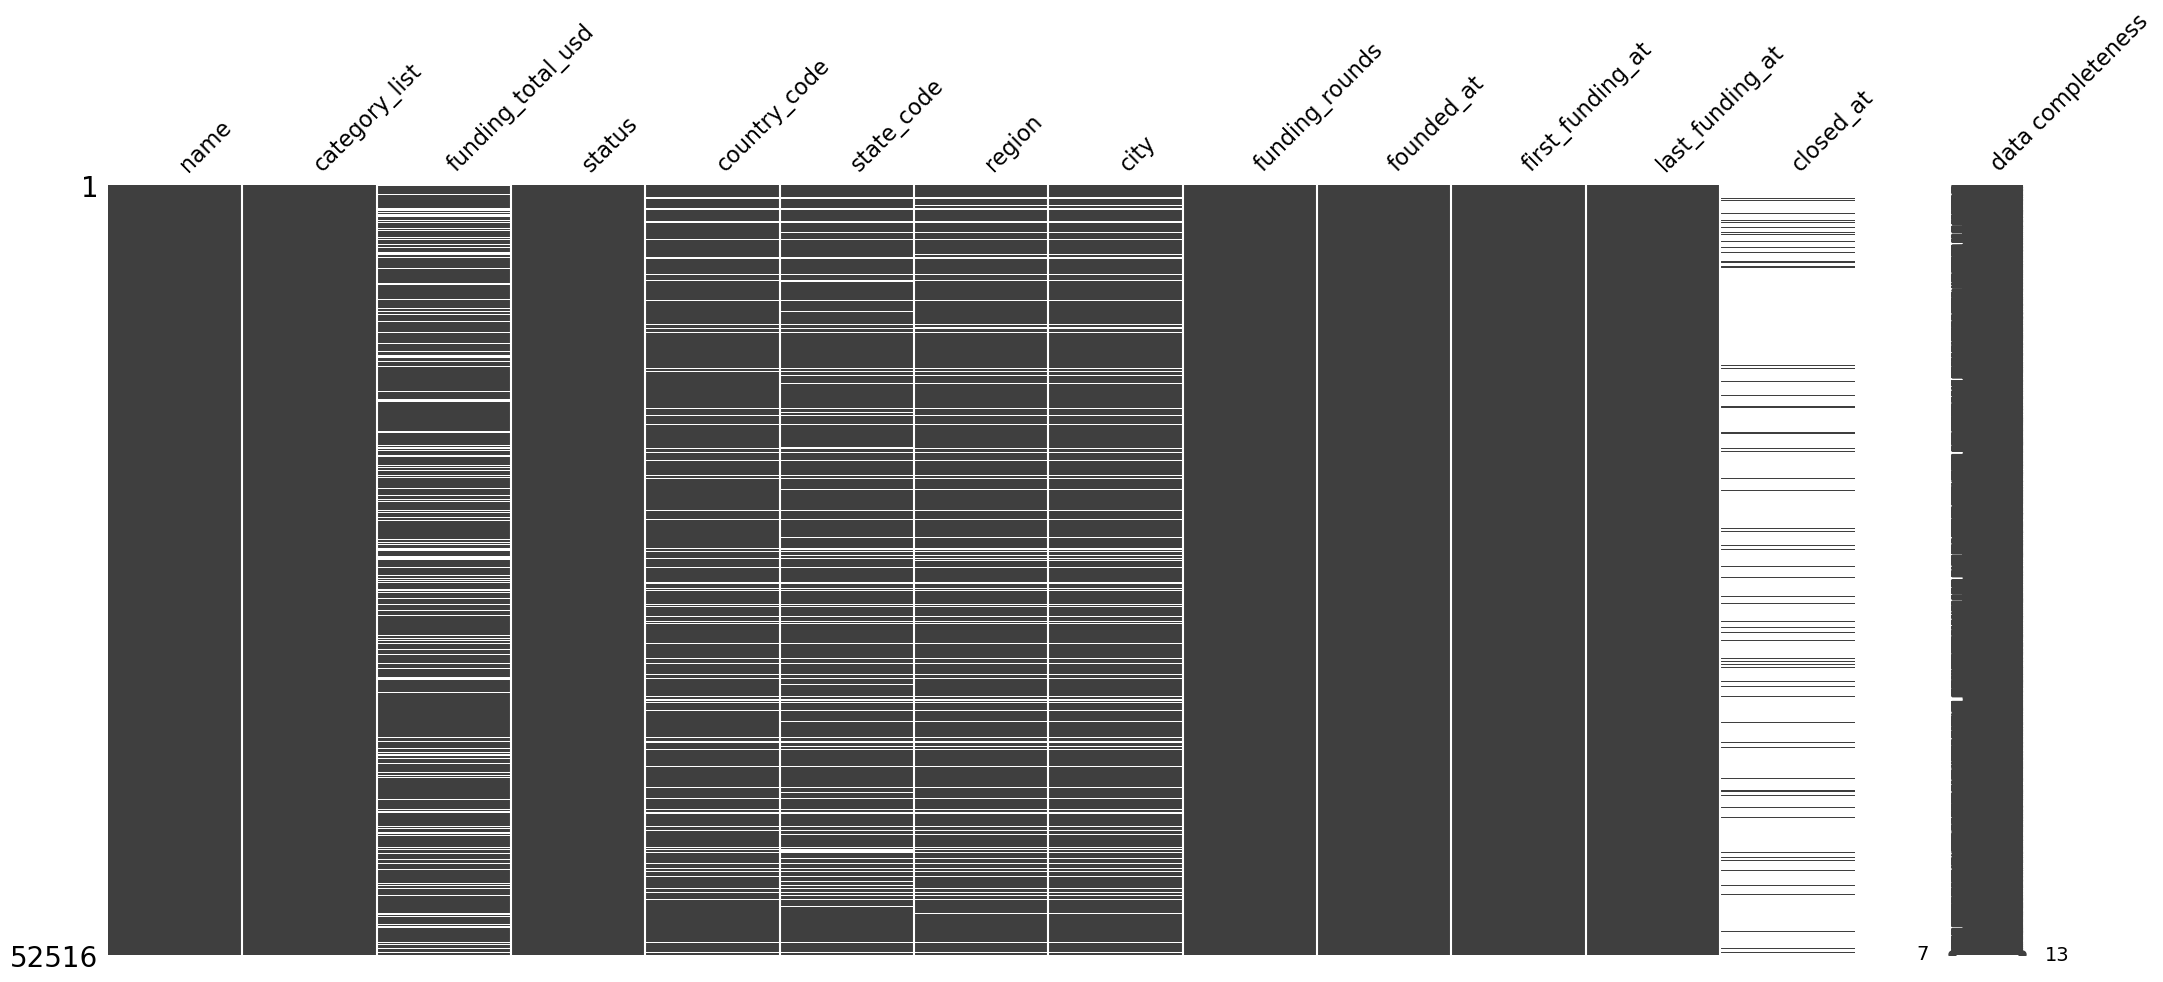

In [803]:
preprocessing(df_train)

In [804]:
# функция для перевода значений в столбцах к нижнему регистру:
def lower (data,column):
    data[column] = data[column].str.lower()

cat_column_train = [
    'name',
    'category_list',
    'status',
    'country_code',
    'state_code',
    'region',
    'city'
]

for row in cat_column_train:
    lower(df_train, row)

<Axes: >

Количество дубликатов: 0


Количество удаленных дубликатов: None


Количество пропущенных значений:


name                    0
category_list           0
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

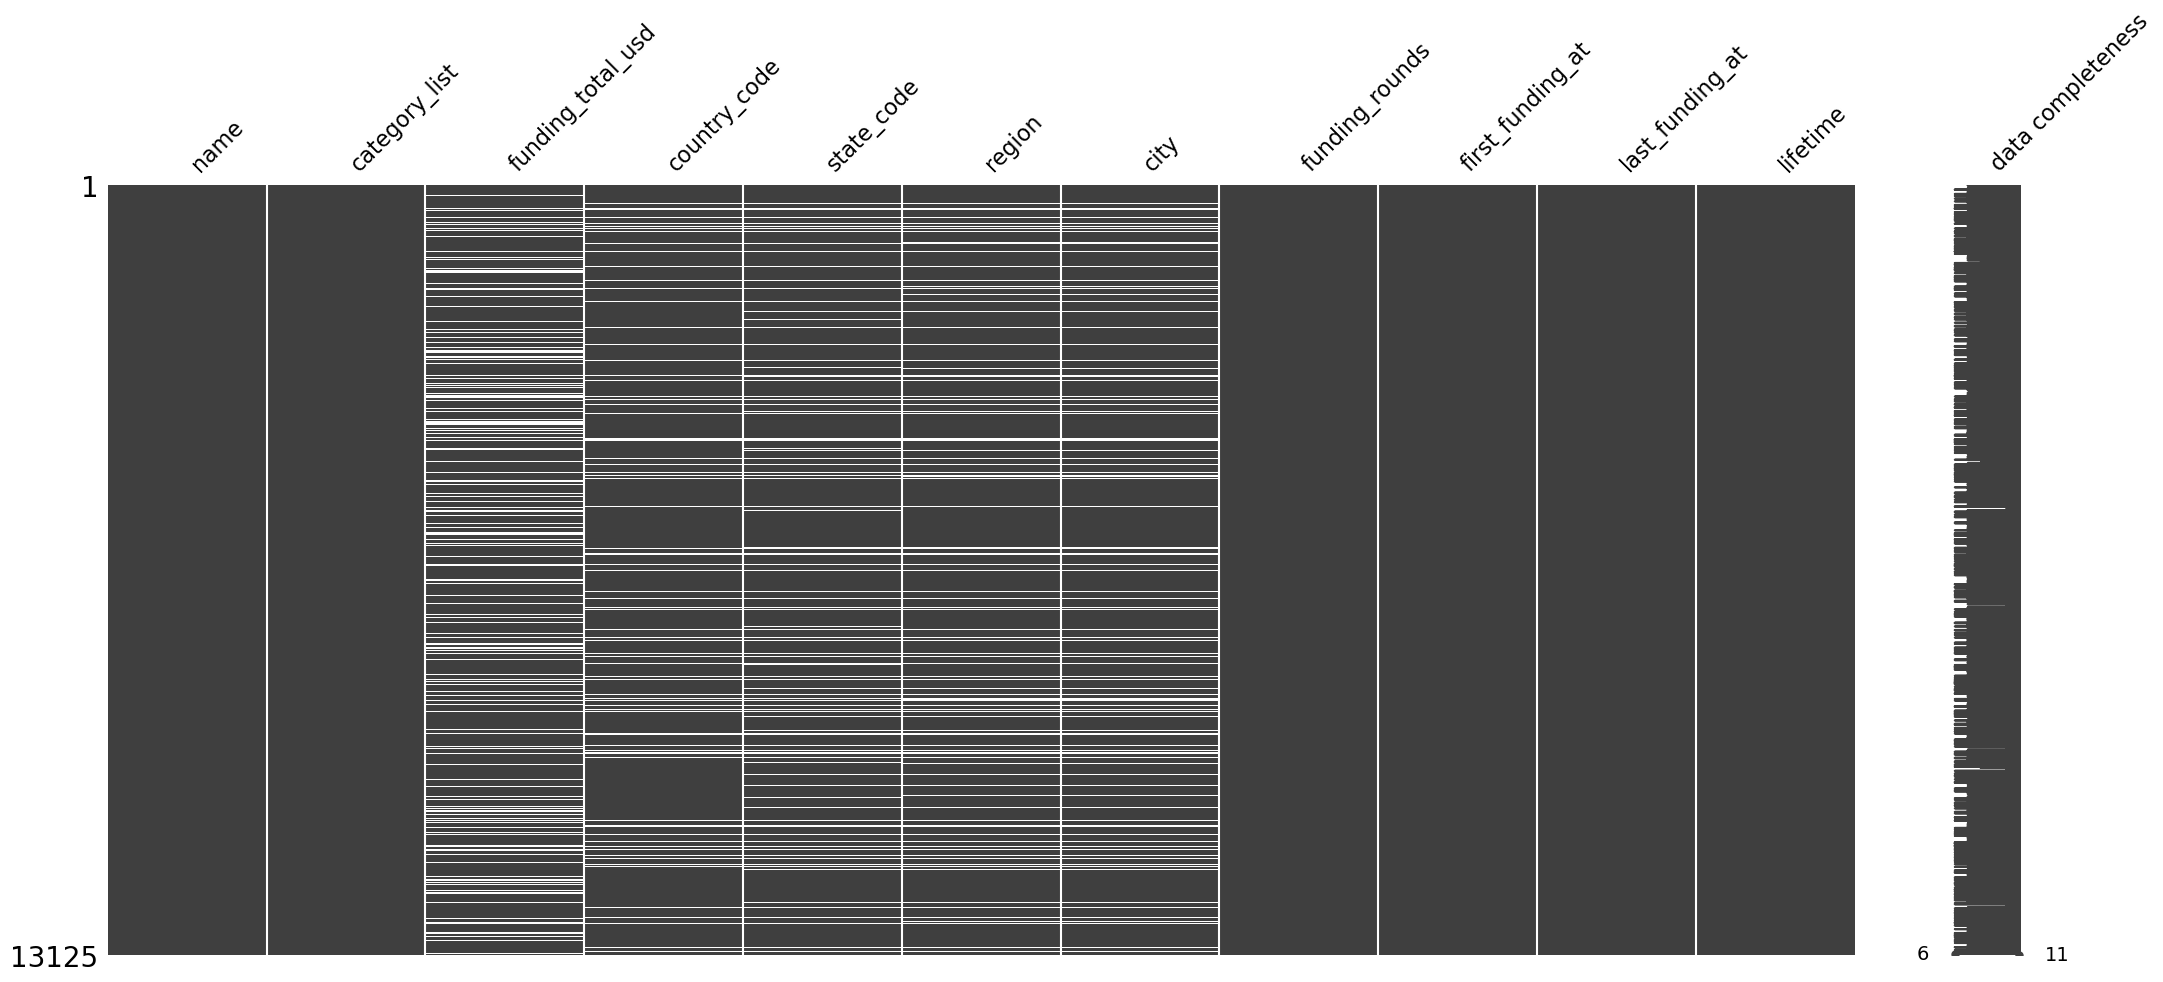

In [805]:
preprocessing(df_test)

In [806]:
cat_column_test= [
    'name',
    'category_list',
    'country_code',
    'state_code',
    'region',
    'city'
]

for row in cat_column_test:
    lower(df_test, row)

**Вывод: Значения в датасеты df_train и df_test привели к нижнему регистру, выявили высокую концентрацию пропущенных значений в столбцах  funding_total_usd, country_code, state_code, region, city. Далее будем делать индивидуальная предобработка по каждому столбцу**

### Индивидуальная предобработка столбцов датасета 'df_train'

#### Столбец 'name' (названия компаний)

In [807]:
# находим пропущенное значение в столбце 'name':
df_train[df_train['name'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,startups,25000.00,closed,usa,or,"portland, oregon",portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [808]:
# восстановить название компании нет возможности, поэтому удалим строку:
df_train = df_train.drop(index=[3291])
# обновим индексы:
df_train = df_train.reset_index(drop=True) 

In [809]:
df_train['name'].value_counts(ascending=False)

name
gust           2
homespace      2
vive           2
webtalk        2
jobcast        2
              ..
pps            1
cardpool       1
cargobr        1
smartcrowdz    1
apparcando     1
Name: count, Length: 52472, dtype: int64

#### Столбец 'category_list' (чем занимается компания)

In [810]:
category_train = df_train['category_list'].value_counts(ascending=False)
category_train.head(5)

category_list
software         3207
biotechnology    2905
                 2465
e-commerce       1064
mobile            920
Name: count, dtype: int64

In [811]:
category_train.tail(5)

category_list
ipad, reviews and recommendations, social television, software, television, video on demand    1
graphics, software, startups                                                                   1
curated web, file sharing, graphics, paas                                                      1
cloud computing, cloud data services, databases, iaas, services, software, virtualization      1
online rental, parking, price comparison                                                       1
Name: count, dtype: int64

In [812]:
# объединим тренировочный и тестовый датасеты:
df_all = [df_train, df_test]

In [813]:
# функция для просмотра уникальных комбинаций деятельности компаний:
def uniq_category(df):
    for i in df_all:
        print([x for x in globals() if globals()[x] is i][0])
        print('\n')
        print('Кол-во уникальных значений:', i['category_list'].apply('nunique'))
        display(i.sample(10, random_state=RANDOM_STATE)['category_list'])
        print()

In [814]:
uniq_category(df_all)

df_train


Кол-во уникальных значений: 22106


19273              charity, non profit, social fundraising
47715    discounts, fashion, marketplaces, personalizat...
543                                           games, video
43293    customer service, customer support tools, util...
34941                    biotechnology, health diagnostics
19756            banking, enterprise software, governments
46499                                          advertising
33089                                       semiconductors
9433                                                 games
30402                 social media, social media platforms
Name: category_list, dtype: object


df_test


Кол-во уникальных значений: 6207


4975                                   enterprise software
11026                                                games
11797    artists globally, concerts, events, social med...
8015                                           curated web
10972                                 education, real time
7628                        apps, communities, photography
11275                                                     
2316                                             analytics
5862     brand marketing, consumers, curated web, lifes...
6041                  banking, finance, financial services
Name: category_list, dtype: object

**Вывод: 22106 уникальных комбинаций в тренировочном датасете, 6207 в тестовом. Из-за большой разницы, попробуем у компаний работающих в режиме многозадачности оставить первое наименование деятельности как главное, но с пометкой что присутствует мультизадачность**

In [815]:
for i in df_all:
    i.loc[i['category_list'].str.contains(',', na=False), 'category_list'] = (i['category_list'].str.split(',').str[0] + '(multitask)')

In [816]:
uniq_category(df_all)

df_train


Кол-во уникальных значений: 1129


19273             charity(multitask)
47715           discounts(multitask)
543                 games(multitask)
43293    customer service(multitask)
34941       biotechnology(multitask)
19756             banking(multitask)
46499                    advertising
33089                 semiconductors
9433                           games
30402        social media(multitask)
Name: category_list, dtype: object


df_test


Кол-во уникальных значений: 793


4975             enterprise software
11026                          games
11797    artists globally(multitask)
8015                     curated web
10972           education(multitask)
7628                 apps(multitask)
11275                               
2316                       analytics
5862      brand marketing(multitask)
6041              banking(multitask)
Name: category_list, dtype: object

**Вывод: теперь нет большого разрыва по уникальным комбинациям деятельности между тренировочным и тестовым датасетами, что должно улучшить обучение моделей и проверку на тестовых данных** 

#### Столбец 'funding_total_usd' (объём финансирования, в долларах США)

In [817]:
# природа пропусков неизвестна, возможно финансирование в принципе отсутствовало, заменим такие пропуски нулевыми значениями:
df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(value=0)

**Вывод: Пропущенные данные заменили на нулевые значения**

#### Столбец 'status' (статус компании, !целевой признак!)

In [818]:
df_train['status'].unique()

array(['operating', 'closed'], dtype=object)

**Вывод: Данный столбец будет использован как целевой признак, пропущенных значений нет, поэтому не трогаем его содержимое**

#### Столбцы 'country_code','state_code', 'region', 'city' (код страны, код штата, регион, город)

In [819]:
def unique_info (df, column):
    df[column].unique()
    
    print(df[column].unique())
    print('\n')
country_columns = [
    'country_code',
    'state_code',
    'region',
    'city'
]
for row in country_columns:
    unique_info(df_train, row)

['che' 'usa' nan 'gbr' 'rus' 'esp' 'fra' 'swe' 'ind' 'kor' 'aus' 'twn'
 'chn' 'hun' 'can' 'fin' 'bra' 'egy' 'prt' 'isr' 'chl' 'svk' 'nld' 'arg'
 'are' 'jpn' 'irl' 'deu' 'lbn' 'est' 'idn' 'bel' 'mex' 'dnk' 'ita' 'grc'
 'rom' 'tur' 'sgp' 'sau' 'mys' 'nga' 'qat' 'vnm' 'bgr' 'gha' 'uga' 'jor'
 'aut' 'pak' 'nzl' 'hkg' 'zaf' 'lva' 'nor' 'hrv' 'ven' 'per' 'lux' 'svn'
 'pol' 'phl' 'nic' 'cze' 'isl' 'pan' 'ury' 'bgd' 'mco' 'gtm' 'tha' 'tto'
 'ukr' 'ken' 'cri' 'dza' 'ltu' 'cym' 'mus' 'blr' 'slv' 'col' 'mlt' 'pse'
 'blz' 'cyp' 'mmr' 'mkd' 'khm' 'gib' 'srb' 'dom' 'bwa' 'blm' 'pry' 'bmu'
 'tan' 'lie' 'grd' 'uzb' 'geo' 'sen' 'alb' 'ecu' 'moz' 'lka' 'lao' 'tun'
 'hnd' 'zwe' 'bah' 'mda' 'maf' 'bhr' 'aze' 'mar' 'kwt' 'irn' 'ggy' 'kna'
 'pri' 'omn' 'kaz' 'jam' 'npl' 'arm' 'tgo' 'rwa' 'brn' 'jey' 'som' 'cmr'
 'mne' 'syc' 'zmb']


['25' 'ca' nan 'va' 'nj' 'tx' 'or' 'fl' 'wa' 'ny' 'c7' 'az' '91' 'ga' 'ma'
 'pa' 'mi' '56' 'mn' 'a8' 'de' '26' 'q5' '7' 'ri' '11' 'c5' 'co' '3' '23'
 '1' 'on' 'il' 'oh' 'k2' '2'

In [820]:
df_train = df_train.dropna(subset=['country_code','state_code', 'region', 'city'], how='all')

In [821]:
df_train.isna().sum()

name                     0
category_list            0
funding_total_usd        0
status                   0
country_code             0
state_code            1261
region                 857
city                   857
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            43383
dtype: int64

In [822]:
display(df_train[df_train['country_code'].isna() & df_train['state_code'].notna()])
display(df_train[df_train['country_code'].isna() & df_train['region'].notna()])
display(df_train[df_train['country_code'].isna() & df_train['city'].notna()])

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [823]:
def replace (df, column):
    df[column] = df[column].fillna(value='no info')
replace_columns = [
    'state_code',
    'region',
    'city'
]
for row in replace_columns:
    replace(df_train, row)

**Вывод: Строки с пропущенными значениями одновременно по 4 стобцам 'country_code','state_code', 'region', 'city' были удалены. Восстановить код страны по региону, городу и коду штата также не получилось. Пропущенные строки в столбах 'state_code', 'region', 'city' заполнены значением 'no info'**

#### Столбец 'funding_rounds' (раунды инвестиций/финансирования)

In [824]:
df_train['funding_rounds'].unique()

array([ 2,  4,  3,  1,  5,  7,  9,  6,  8, 10, 11, 12, 15, 13, 16, 17, 14,
       18, 19], dtype=int64)

**Вывод: Пропущенных значений нет. Раунды инвестиций представлены в диапозоне от 1 до 19 раундов**

#### Столбцы 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at' (дата основания компании, дата первой инвестиции, дата последней инвестиции, дата закрытия компании)

In [825]:
date_columns = [
    'founded_at',
    'first_funding_at',
    'last_funding_at',
    'closed_at'
]

for row in date_columns:
    unique_info(df_train, row)

['2009-10-17' '2005-01-01' '2006-01-01' ... '1996-07-17' '2006-08-26'
 '2004-01-11']


['2011-05-01' '2010-05-04' '2012-08-20' ... '2009-03-15' '2009-06-14'
 '1998-11-30']


['2014-12-01' '2014-02-25' '2014-07-02' ... '2004-01-21' '2007-04-10'
 '2009-03-15']


[nan '2014-09-04' '2012-02-26' ... '2017-03-24' '2014-05-04' '2007-03-05']




In [826]:
df_train.query('status == "closed"')[['status','closed_at']].isna().sum()

status       0
closed_at    0
dtype: int64

In [827]:
df_train.query('status == "operating"')[['status','closed_at']].isna().sum()

status           0
closed_at    43383
dtype: int64

**Вывод: Большое кол-во пропусков в столбце 'closed_at' из-за того, что компании со статусом 'closed' имеют дату закрытия, а у компаний со статусом 'operating' такой даты нет, что превращается в пропущенное значение. По условию задания дата формирования выгрузки 2018-01-01 т.е будет логично все пропущенные значения заменить на эту дату.**

In [828]:
df_train['closed_at'] = df_train['closed_at'].fillna(value='2018-01-01')

In [829]:
# функция для преобразования данных из 'object' в 'datetime'
def date_time (df, column):
    df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')
for row in date_columns:
    date_time(df_train, row)

In [830]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47013 entries, 0 to 52514
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               47013 non-null  object        
 1   category_list      47013 non-null  object        
 2   funding_total_usd  47013 non-null  float64       
 3   status             47013 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         47013 non-null  object        
 6   region             47013 non-null  object        
 7   city               47013 non-null  object        
 8   funding_rounds     47013 non-null  int64         
 9   founded_at         47013 non-null  datetime64[ns]
 10  first_funding_at   47013 non-null  datetime64[ns]
 11  last_funding_at    47013 non-null  datetime64[ns]
 12  closed_at          47013 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

**Вывод: тип данных преобразован в datetime**

In [831]:
def max_min_values (df, column):
    df[column].max()
    df[column].min()
    print(df[column].max())
    print(df[column].min())
    print('\n')

for row in date_columns:
    max_min_values(df_train, row)

2016-01-01 00:00:00
1970-06-04 00:00:00


2015-12-05 00:00:00
1977-05-15 00:00:00


2015-12-07 00:00:00
1977-05-15 00:00:00


2018-01-01 00:00:00
1983-12-14 00:00:00




**Вывод: значения дат находятся в корректных диапазонах, которые соответствуют временному периоду с 1970-01-01 по 2018-01-01**

<Axes: >

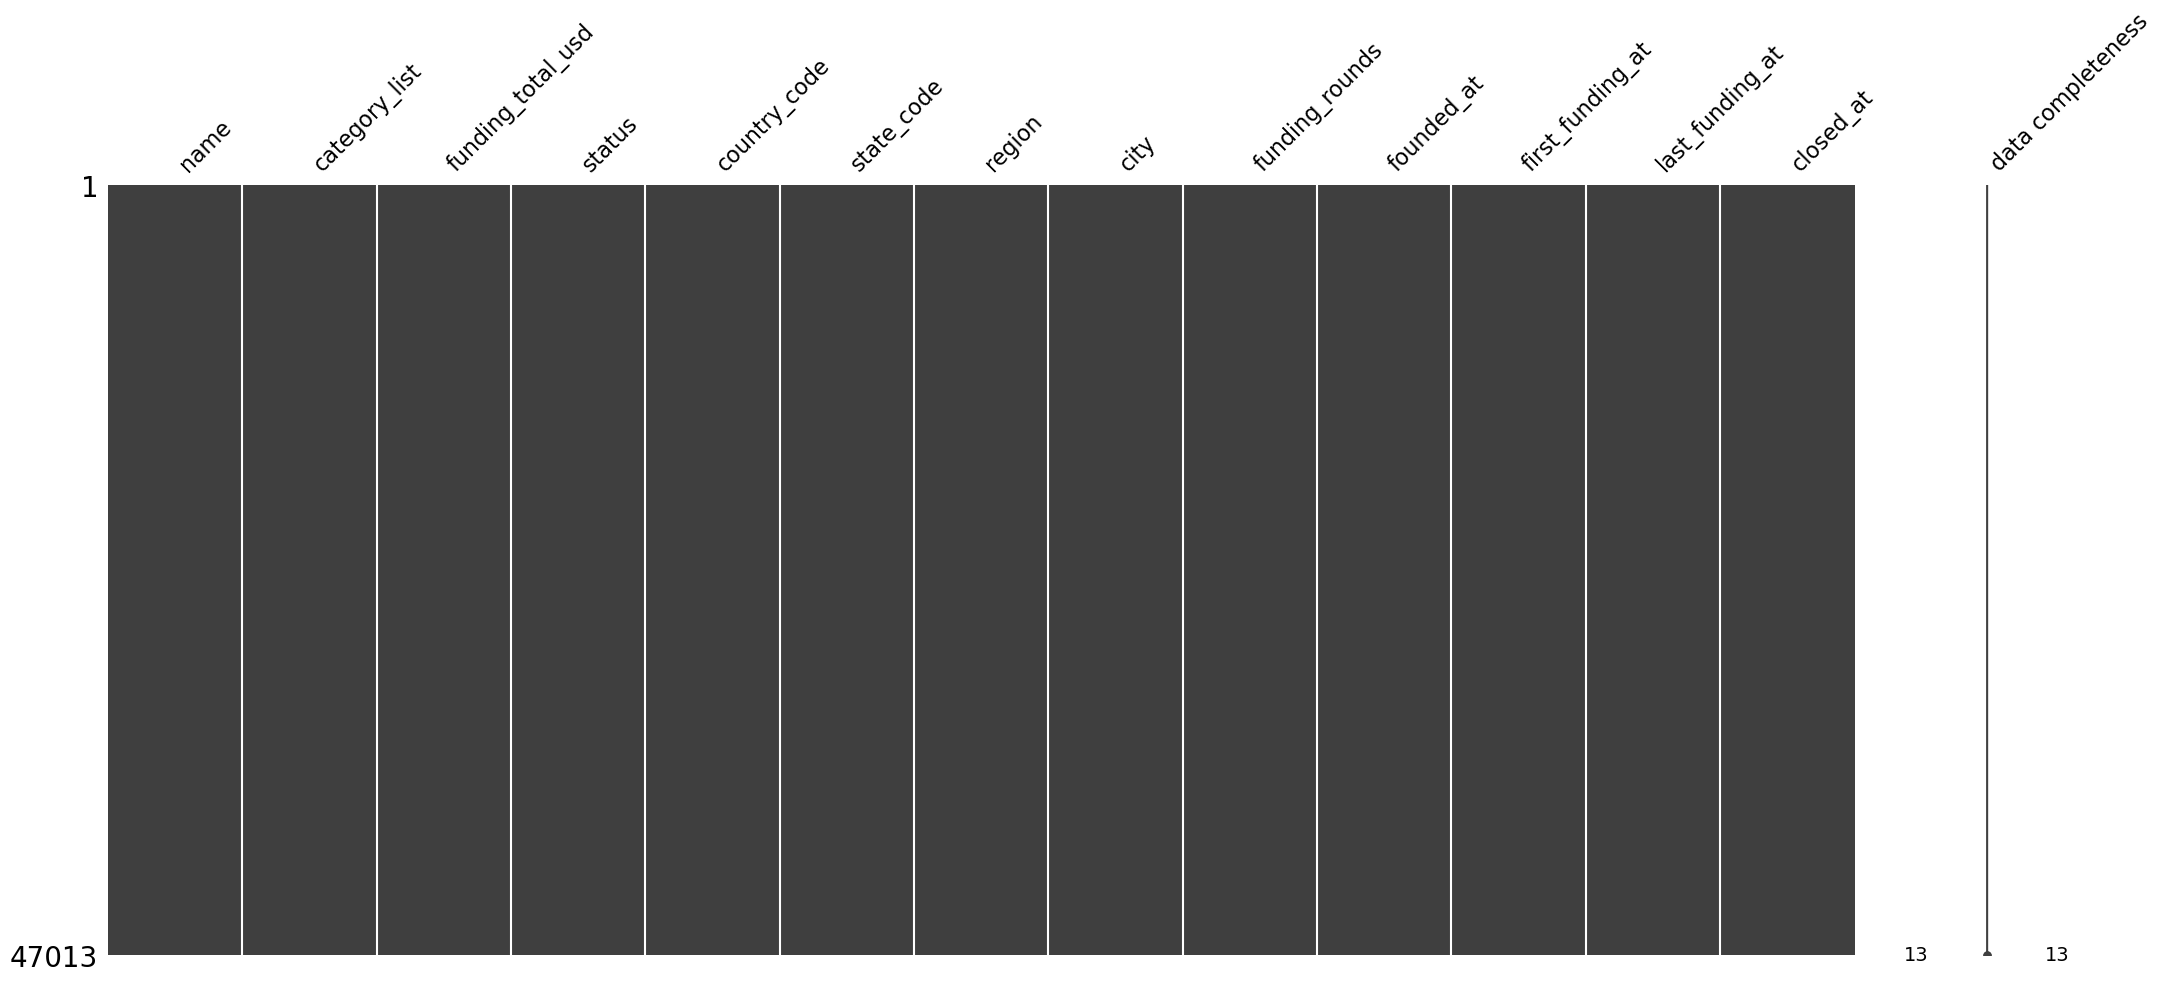

In [832]:
msno.matrix(df_train, labels=True)

**Вывод: предобработка данных по датасету 'df_train' завершена. Потеря данных составила 11,7%, но качество данных улучшилось т.к избавились от пропущенных значений. Это позволит улучшшить качество обучения модели. Датасет достаточно объёмный (52516 значений на старте) оставшихся после предобработки данных (47013 значений) должно хватить для качественного обучения моделей.**

### Индивидуальная предобработка датасета 'df_test'

#### Столбец 'name' (названия компаний)

In [833]:
df_test[df_test['name'].isnull()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [834]:
df_test['name'].value_counts(ascending=False)

name
spoke                      2
quip                       2
crystalsol                 1
radius app                 1
conatus pharmaceuticals    1
                          ..
instapagar                 1
mobitx                     1
datawiz.io                 1
mempile                    1
ringcentral                1
Name: count, Length: 13123, dtype: int64

**Вывод: здесь всё в порядке**

#### Столбец 'category_list' (чем занимается компания)

**Вывод: в этом столбце также решили вопросы**

#### Столбец 'funding_total_usd' (объём финансирования, в долларах США)

In [835]:
# природа пропусков неизвестна, возможно финансирование в принципе отсутствовало, заменим такие пропуски нулевыми значениями:
df_test['funding_total_usd'] = df_test['funding_total_usd'].fillna(value=0)

**Вывод: Пропущенные данные заменили на нулевые значения**

#### Столбцы 'country_code','state_code', 'region', 'city' (код страны, код штата, регион, город)

In [836]:
for row in country_columns:
    unique_info(df_test, row)

['nic' 'usa' 'lux' 'can' nan 'mys' 'deu' 'gbr' 'fra' 'ita' 'chn' 'arg'
 'nld' 'irl' 'aus' 'che' 'chl' 'esp' 'ind' 'isr' 'dnk' 'kor' 'rus' 'phl'
 'ury' 'sgp' 'bra' 'egy' 'mex' 'pol' 'vnm' 'aut' 'est' 'bel' 'dma' 'prt'
 'swe' 'jor' 'hun' 'hkg' 'jpn' 'zaf' 'col' 'bgr' 'cze' 'grc' 'ltu' 'twn'
 'isl' 'idn' 'fin' 'nor' 'are' 'ukr' 'ken' 'nga' 'tur' 'cri' 'tha' 'cyp'
 'rom' 'mmr' 'ven' 'bhr' 'nzl' 'svk' 'cym' 'lva' 'mkd' 'per' 'aze' 'bwa'
 'bgd' 'zwe' 'civ' 'lka' 'svn' 'srb' 'blr' 'tan' 'sau' 'gha' 'cmr' 'tto'
 'pak' 'bmu' 'pse' 'uga' 'mus' 'jam' 'lbn' 'ecu' 'pan' 'gtm' 'hrv' 'brb'
 'zmb']


['17' 'tn' '3' 'ca' 'on' nan 'va' 'pa' 'az' '14' '7' 'al' 'ma' 'ny' '16'
 'h9' 'ga' 'i9' 'qc' 'fl' 'wa' 'oh' 'co' 'a8' 'ms' '18' '22' 'dc' 'nc'
 'c7' '15' '4' '2' 'tx' '24' '12' '51' '36' 'mo' '5' 'h3' '19' '23' 'nj'
 'md' 'k2' 'mi' '11' '9' '48' 'd9' 'b3' 'in' 'ks' '10' 'a6' 'sc' 'ut' 'or'
 'il' '28' 'bc' '56' '78' 'la' '1' 'a9' '29' '13' 'ri' 'b6' 'mn' 'u8' 'v2'
 'ct' 'ky' 'wi' '26' 'p6' 'nm' '72' 'ia' 

In [837]:
df_test = df_test.dropna(subset=['country_code','state_code', 'region', 'city'], how='all')

In [838]:
display(df_test[df_test['country_code'].isna() & df_test['state_code'].notna()])
display(df_test[df_test['country_code'].isna() & df_test['region'].notna()])
display(df_test[df_test['country_code'].isna() & df_test['city'].notna()])

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [839]:
for row in replace_columns:
    replace(df_test, row)

**Вывод: Строки с пропущенными значениями одновременно по 4 стобцам 'country_code','state_code', 'region', 'city' были удалены. Восстановить код страны по региону, городу и коду штата также не получилось. Пропущенные строки в столбах 'state_code', 'region', 'city' заполнены значением 'no info'**

#### Столбец 'funding_rounds' (раунды инвестиций/финансирования)

In [840]:
df_test['funding_rounds'].unique()

array([ 1,  2,  4,  5,  3,  6,  7, 10, 12,  8,  9, 11, 13, 15, 14],
      dtype=int64)

**Вывод: Пропущенных значений нет. Раунды инвестиций представлены в диапозоне от 1 до 14 раундов**

#### Столбцы 'first_funding_at', 'last_funding_at', 'lifetime' (дата первой инвестиции, дата последней инвестиции, дата закрытия компании, продолжительность жизни компании (в днях))

In [841]:
date_columns_test = [
    'first_funding_at',
    'last_funding_at',
    'lifetime'
]

for row in date_columns_test:
    unique_info(df_test, row)

['2009-07-01' '2010-07-28' '2014-05-15' ... '1995-06-01' '2014-09-27'
 '2007-01-16']


['2009-07-01' '2010-07-28' '2014-09-18' ... '2011-01-13' '2007-08-31'
 '2009-11-27']


[3501 2717 1295 ... 1074 4365 8711]




In [842]:
date_columns_test = [
    'first_funding_at',
    'last_funding_at'
]

for row in date_columns_test:
    date_time(df_test, row)

In [843]:
for row in date_columns_test:
    max_min_values(df_test, row)

2015-12-03 00:00:00
1973-04-15 00:00:00


2015-12-12 00:00:00
1973-04-15 00:00:00




**Вывод: значения дат находятся в корректных диапазонах, которые соответствуют временному периоду с 1970-01-01 по 2018-01-01**

In [844]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11743 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               11743 non-null  object        
 1   category_list      11743 non-null  object        
 2   funding_total_usd  11743 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11743 non-null  object        
 5   region             11743 non-null  object        
 6   city               11743 non-null  object        
 7   funding_rounds     11743 non-null  int64         
 8   first_funding_at   11743 non-null  datetime64[ns]
 9   last_funding_at    11743 non-null  datetime64[ns]
 10  lifetime           11743 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


<Axes: >

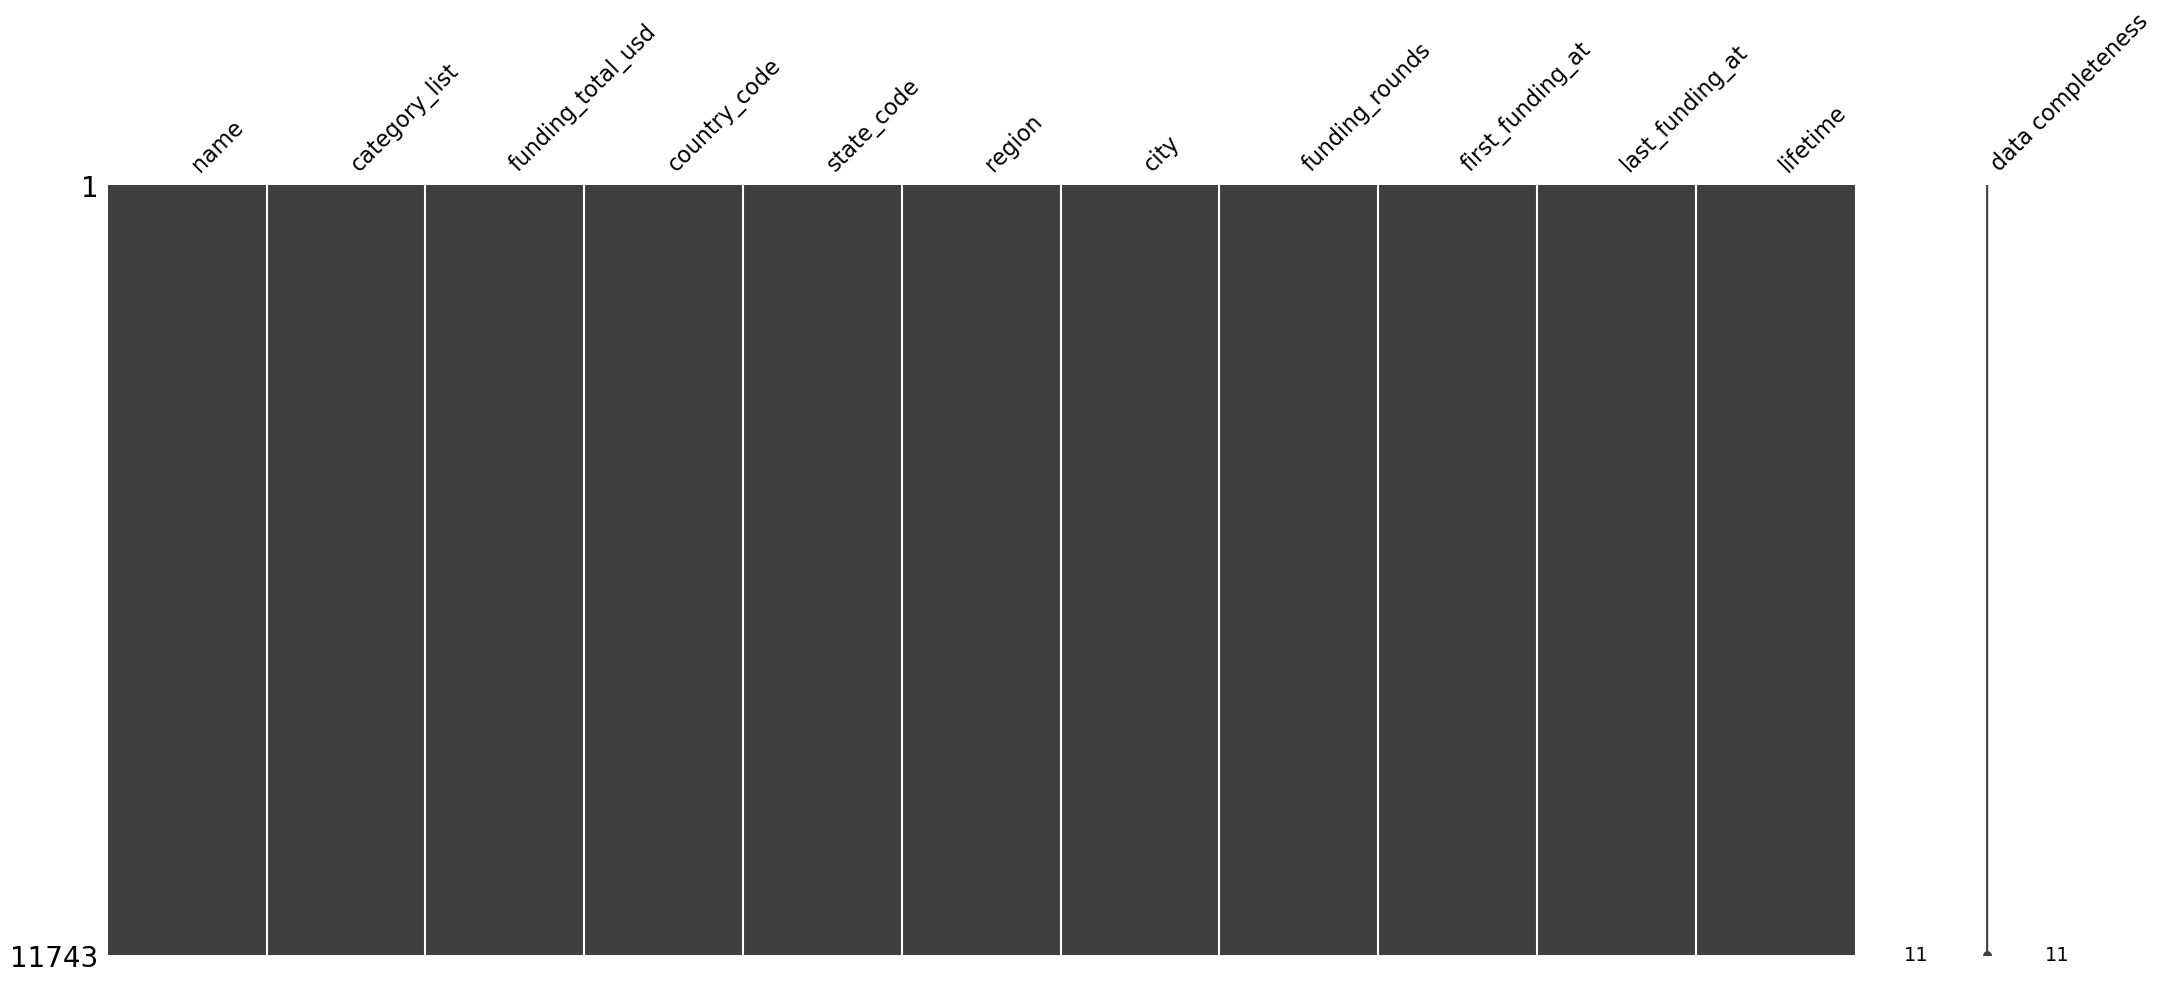

In [845]:
msno.matrix(df_test, labels=True)

**Вывод: предобработка данных по датасету 'df_test' завершена. Потеря данных составила 11,7%, но качество данных улучшилось т.к избавились от пропущенных значений. Это позволо улучшшить качество тестовых данных. В датасете 'df_test' было 13125 значений на старте, после предобработки осталось 11743 значения которых должно хватить для качественного тестирования моделей.**

### Исследовательский анализ данных

#### Анализ количественных признаков

In [846]:
df_test.sample(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
7877,netstreams,games,20950000.00,usa,tx,austin,austin,3,2004-01-01,2009-01-15,5784
9482,floxx,social media,300000.00,gbr,h9,london,london,1,2010-12-01,2010-12-01,2555
9137,gramvaani,audio(multitask),500000.00,ind,7,new delhi,new delhi,1,2013-07-08,2013-07-08,3287


In [847]:
df_train.sample(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
11174,opower,clean technology(multitask),65700000.00,operating,usa,va,"washington, d.c.",arlington,3,2007-01-01,2007-08-01,2010-11-29,2018-01-01
3579,creating solutions consulting,consulting,0.00,operating,usa,oh,cleveland,euclid,1,2013-04-01,2013-10-17,2013-10-17,2018-01-01
26420,qualaris healthcare solutions,health and wellness,100000.00,operating,usa,pa,pittsburgh,pittsburgh,2,2011-01-01,2013-12-03,2014-02-21,2018-01-01


In [848]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11743 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               11743 non-null  object        
 1   category_list      11743 non-null  object        
 2   funding_total_usd  11743 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11743 non-null  object        
 5   region             11743 non-null  object        
 6   city               11743 non-null  object        
 7   funding_rounds     11743 non-null  int64         
 8   first_funding_at   11743 non-null  datetime64[ns]
 9   last_funding_at    11743 non-null  datetime64[ns]
 10  lifetime           11743 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [849]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47013 entries, 0 to 52514
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               47013 non-null  object        
 1   category_list      47013 non-null  object        
 2   funding_total_usd  47013 non-null  float64       
 3   status             47013 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         47013 non-null  object        
 6   region             47013 non-null  object        
 7   city               47013 non-null  object        
 8   funding_rounds     47013 non-null  int64         
 9   founded_at         47013 non-null  datetime64[ns]
 10  first_funding_at   47013 non-null  datetime64[ns]
 11  last_funding_at    47013 non-null  datetime64[ns]
 12  closed_at          47013 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

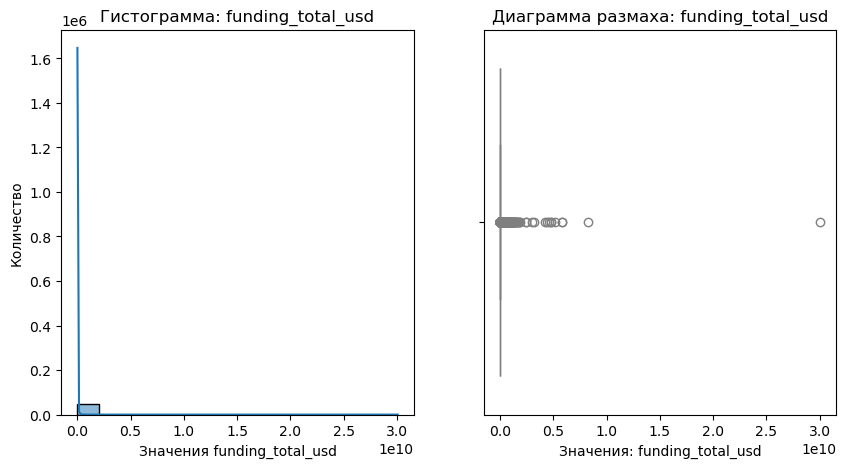

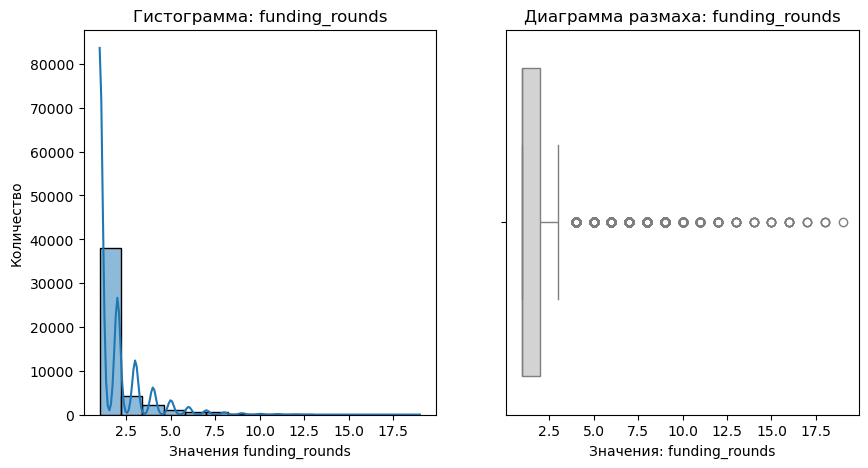

In [850]:
# функция:
def hist (data, column):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.xlabel(f'Значения {column}')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма: {column}')
    sns.histplot(data=data, x=column, kde=True, bins = 15)
    plt.subplot(1,2,2)
    plt.xlabel(f'Значения: {column}')
    plt.title(f'Диаграмма размаха: {column}')
    sns.boxplot(x=data[column], color='LightGrey')

# список количественных столбцов:
num_col_train = [
    'funding_total_usd',
    'funding_rounds'
]

# активируем функцию:
for row in num_col_train:
    hist(df_train, row)

**Вывод: судя по диаграмме размаха в стобце 'funding_total_usd' есть 1 сверхбольшое значение, но возможно оно соответствует действительности.  Большинство стартапов привлекали относительно небольшие суммы инвестиций. Также можно сказать, что в основном стартапы проходили небольшое количество раундов инвестиций.**

In [851]:
# посмотрим мин. макс. значения у компаний, которые находятся в рабочем режиме:
df_operating = df_train[df_train['status'] == 'operating']
df_operating['funding_total_usd'].describe()

count         43383.00
mean       15908948.75
std       175468160.84
min               0.00
25%           62500.00
50%         1140000.00
75%         7772550.00
max     30079503000.00
Name: funding_total_usd, dtype: float64

In [852]:
df_train[df_train['funding_total_usd'] == 30079503000.00]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
39185,verizon communications,communications infrastructure(multitask),30079503000.00,operating,usa,ny,new york city,new york,5,1983-10-07,2010-01-26,2014-02-28,2018-01-01


In [853]:
#  удалим из тренировочного датасета макс. значение:
df_train = df_train.drop(index=[39185])
df_train = df_train.reset_index(drop=True)

**Вывод: Вполне допустиммая сумма для телекоммуникационного гиганта Verizon, но удалим для улучшения однородности данных и общей статистики.**

In [854]:
# посмотрим мин. макс. значения у компаний, которые закрылись:
df_closed = df_train[df_train['status'] == 'closed']
df_closed['funding_total_usd'].describe()

count         3630.00
mean       9777716.11
std       43179418.06
min              0.00
25%          50000.00
50%         967000.00
75%        6000000.00
max     1567504319.00
Name: funding_total_usd, dtype: float64

In [855]:
df_closed[df_closed['funding_total_usd'] == 1567504319.00]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16705,solyndra,manufacturing,1567504319.00,closed,usa,ca,sf bay area,fremont,8,2005-01-01,2006-01-01,2011-06-16,2012-07-26


In [856]:
#  удалим из тренировочного датасета макс. значение:
df_train = df_train.drop(index=[18681])
df_train = df_train.reset_index(drop=True)

**Вывод: Судя по открытым источникам в интернете компания реальная, и провалилась она реально. Также удалим для улучшения однородности данных и общей статистики.**

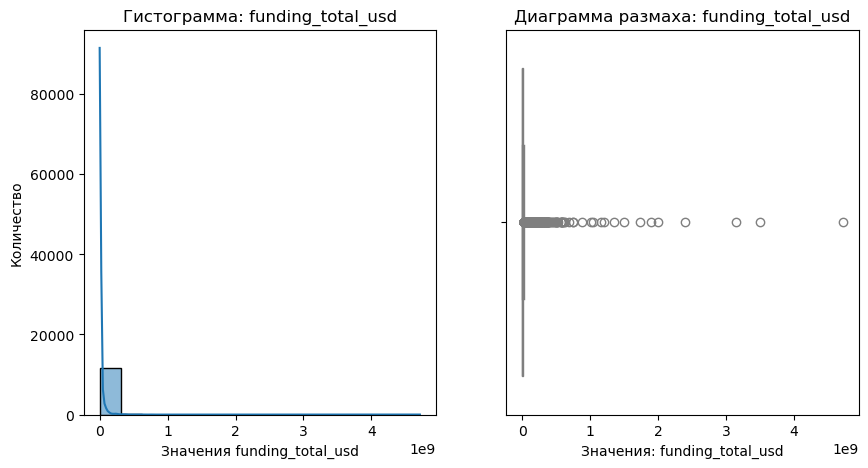

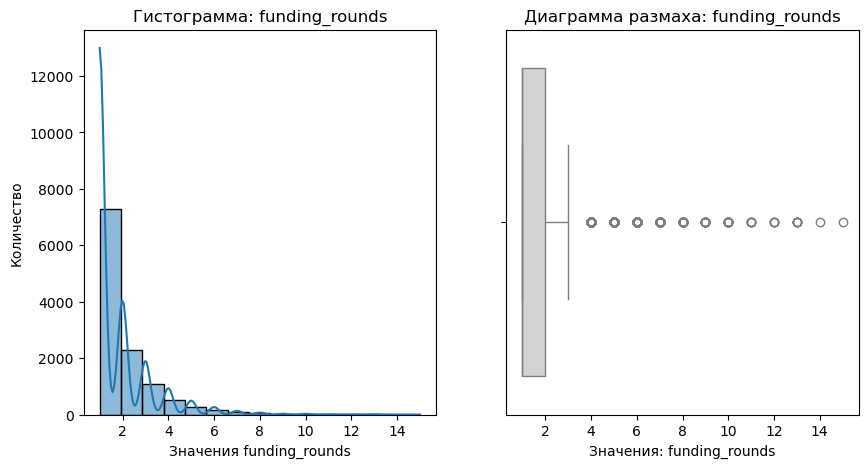

In [857]:
for row in num_col_train:
    hist(df_test, row)

In [858]:
# посмотрим мин. макс. значения у компаний:
df_test['funding_total_usd'].describe()

count        11743.00
mean      14189714.16
std       86356103.76
min              0.00
25%          52055.00
50%        1040000.00
75%        7500000.00
max     4715000000.00
Name: funding_total_usd, dtype: float64

In [859]:
df_test[df_test['funding_total_usd'] == 4715000000.00]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
6448,mediavast,advertising(multitask),4715000000.00,usa,ny,new york city,new york,2,2003-06-30,2006-05-17,6940


In [860]:
#  удалим из тестового датасета макс. значение:
df_test = df_test.drop(index=[6448])
df_test = df_test.reset_index(drop=True)

**Вывод: За счёт удаления выбивающегося из основной массы значения, категориальные данные с тестовом датасете стали более однородными. У тестовой выборки практически такие же зависимости как у тренировочной, поялвляется новый признак, время существования компании**

#### Анализ категориальных признаков

In [861]:
country_count = df_train.groupby('country_code').agg({'name': 'count'}).sort_values(by='name', ascending=False).reset_index().head(15)
country_count.columns =['код страны', 'количество']

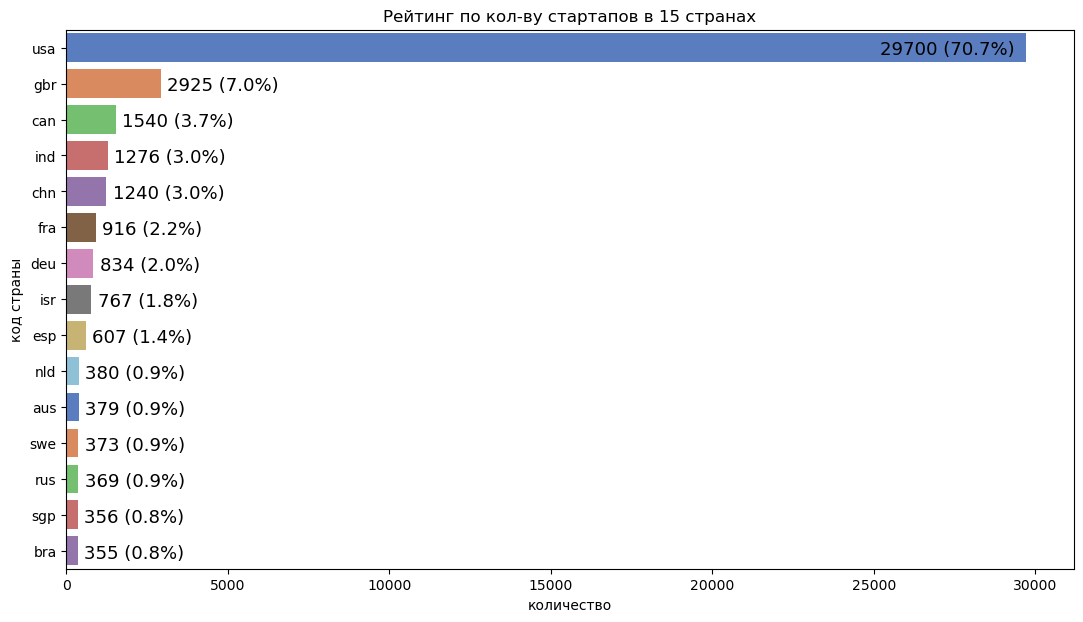

In [862]:
plt.figure(figsize=(13, 7))
ax = sns.barplot(y='код страны', x='количество', data=country_count, palette=sns.color_palette('muted', 15), hue='код страны', legend=False)
ax.set_title('Рейтинг по кол-ву стартапов в 15 странах')
for i in ax.patches:
    if i.get_width() > 10000:
        ax.text(i.get_width()-4500, i.get_y()+0.60, 
                str(int(i.get_width())) + ' ({:.1%})'.format(i.get_width() / country_count.количество.sum()), fontsize=13, color='black')
    if 10000 > i.get_width():
        ax.text(i.get_width()+200, i.get_y()+0.6, 
                str(int(i.get_width())) + ' ({:.1%})'.format(i.get_width() / country_count.количество.sum()), fontsize=13, color='black')
plt.show()

In [863]:
category_count = df_train.groupby('category_list').agg({'name': 'count'}).sort_values(by='name', ascending=False).reset_index().head(15)
category_count.columns =['список категорий', 'количество']

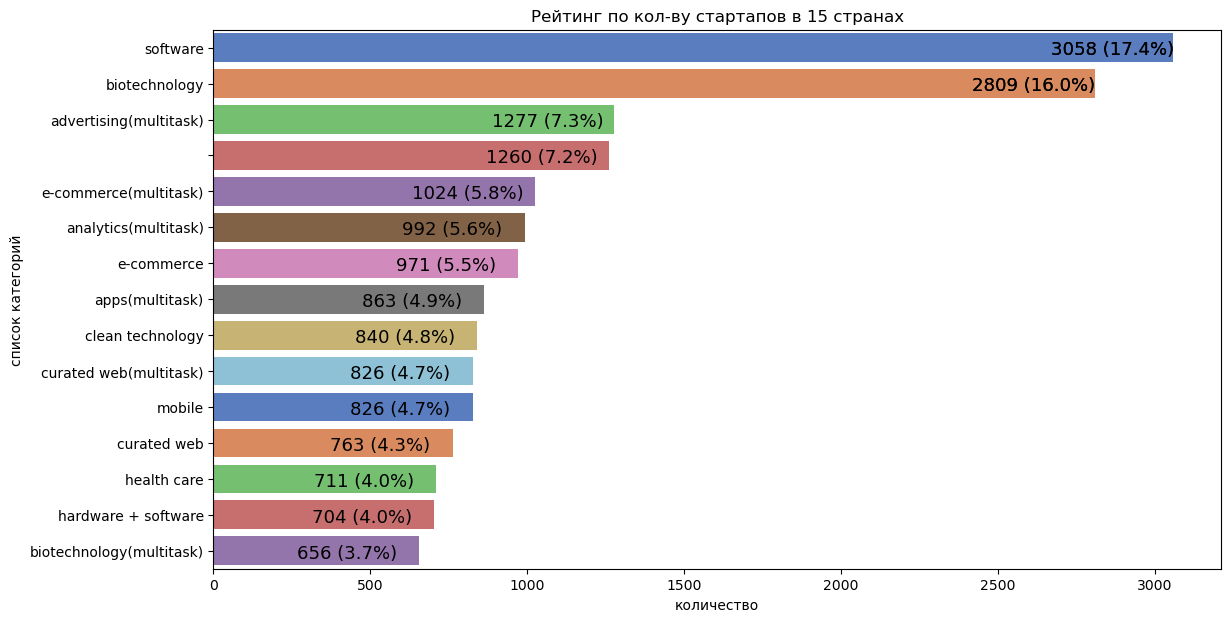

In [864]:
plt.figure(figsize=(13, 7))
ax = sns.barplot(y='список категорий', x='количество', data=category_count, palette=sns.color_palette('muted', 15), hue='список категорий', legend=False)
ax.set_title('Рейтинг по кол-ву стартапов в 15 странах')
for i in ax.patches:
    if i.get_width() > 1500:
        ax.text(i.get_width()-390, i.get_y()+0.6, 
                str(int(i.get_width())) + ' ({:.1%})'.format(i.get_width() / category_count.количество.sum()), fontsize=13, color='black')
    if 10000 > i.get_width():
        ax.text(i.get_width()-390, i.get_y()+0.6, 
                str(int(i.get_width())) + ' ({:.1%})'.format(i.get_width() / category_count.количество.sum()), fontsize=13, color='black')
plt.show()

<Figure size 1300x400 with 0 Axes>

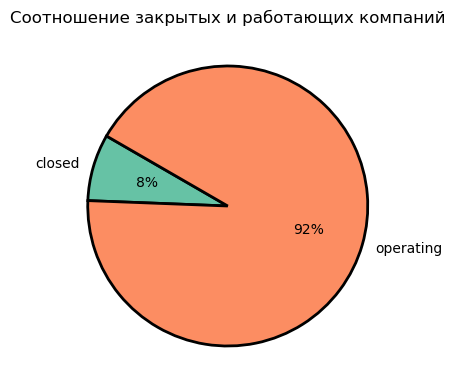

In [865]:
def pie_categorical(data, column, i, l, n):
    plt.figure(figsize=(16,10))
    plt.subplot(2, l, n)
    plt.title(f'Соотношение закрытых и работающих компаний')
    plt.pie(x=data.groupby(column)[row].count(),
           startangle=150,
           labeldistance=1.1,
           wedgeprops = {'linewidth':2, 'edgecolor':'black'},
           autopct = '%.0f%%',
           labels = data.groupby(column)[row].count().index,
           colors = sns.color_palette('Set2')[0:10])

status_count = ['status']

n = 1
plt.figure(figsize=(13,4))
for row in status_count:
    pie_categorical(df_train, row, 'name', len(status_count), n)
    n += 1

**Вывод:** 

- **Самые популярные категории деятельности компаний:**
    - Програмное обеспечение (17,4%);
    - Биотехнологии (16%).
- **Самые популярные страны по кол-ву стартапов:**
    - США - 70,7%;
    - Великобритания - 7%.
- **Соотношение закрытых и работающих компаний:**
    - 8% закрылись;
    - 92% продолжают работать.
- **Максимальное кол-во раундов инвестиций 19, но чаще всего 1**.

### Создание дополнительных (синтетических признаков)

In [866]:
df_train['closed_at'] = df_train['closed_at'].fillna(pd.Timestamp('2018-01-01').strftime('%Y-%m-%d'))

In [867]:
# 1 признак:
df_train['lifetime_1'] = (df_train['closed_at'] - df_train['founded_at']).dt.days

In [868]:
# 2 признак:
df_train['lifetime_2'] = (df_train['closed_at'] - df_train['first_funding_at']).dt.days

In [869]:
df_train.sample(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime_1,lifetime_2
7041,identiv,data security(multitask),20000000.00,operating,usa,ca,sf bay area,fremont,1,2007-01-01,2014-04-02,2014-04-02,2018-01-01,4018,1370
29981,storenvy,e-commerce(multitask),6525000.00,operating,usa,ca,sf bay area,san francisco,2,2010-08-01,2011-01-01,2013-02-12,2018-01-01,2710,2557
3451,cupomnow,coupons(multitask),1500000.00,closed,bra,21,rio de janeiro,rio de janeiro,2,2011-07-26,2011-07-01,2011-11-01,2012-12-30,523,548


In [870]:
df_train['lifetime_1'].isna().sum()

0

In [871]:
df_train['lifetime_2'].isna().sum()

0

In [872]:
df_train['lifetime_1'].describe()

count   47011.00
mean     3227.62
std      2165.55
min        19.00
25%      1826.00
50%      2557.00
75%      4018.00
max     17378.00
Name: lifetime_1, dtype: float64

In [873]:
df_train['lifetime_2'].describe()

count   47011.00
mean     2197.47
std      1297.82
min       360.00
25%      1266.00
50%      1846.00
75%      2841.50
max     14841.00
Name: lifetime_2, dtype: float64

In [874]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47011 entries, 0 to 47010
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               47011 non-null  object        
 1   category_list      47011 non-null  object        
 2   funding_total_usd  47011 non-null  float64       
 3   status             47011 non-null  object        
 4   country_code       47011 non-null  object        
 5   state_code         47011 non-null  object        
 6   region             47011 non-null  object        
 7   city               47011 non-null  object        
 8   funding_rounds     47011 non-null  int64         
 9   founded_at         47011 non-null  datetime64[ns]
 10  first_funding_at   47011 non-null  datetime64[ns]
 11  last_funding_at    47011 non-null  datetime64[ns]
 12  closed_at          47011 non-null  datetime64[ns]
 13  lifetime_1         47011 non-null  int64         
 14  lifeti

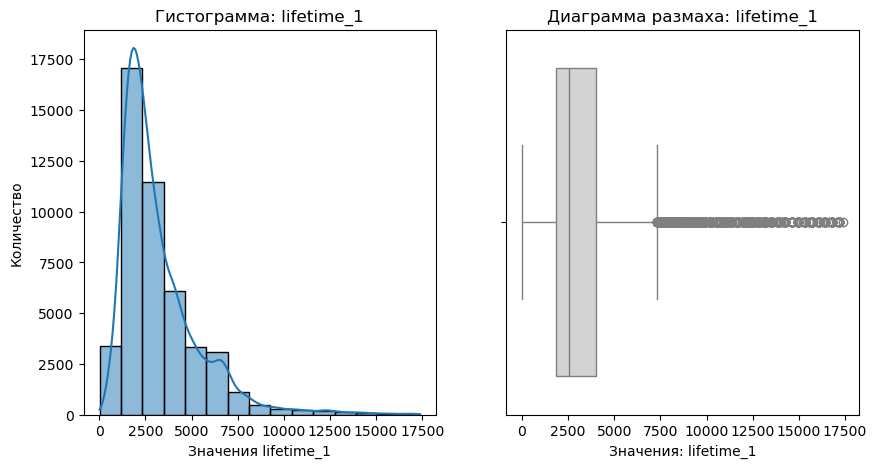

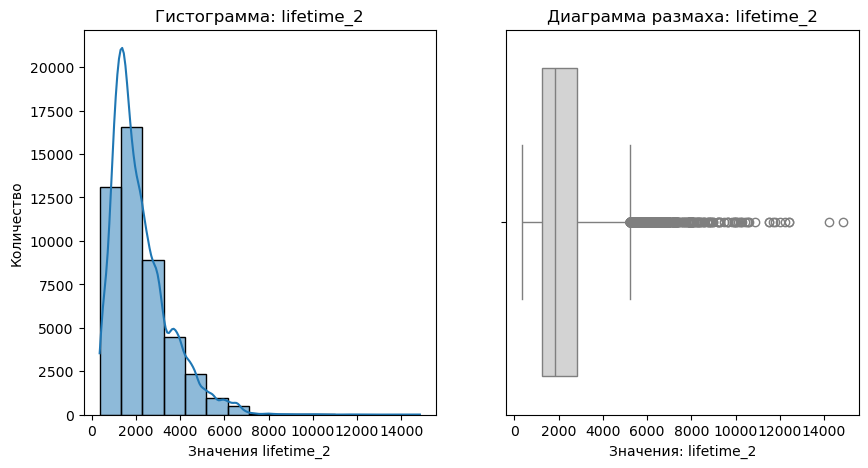

In [875]:
# список количественных столбцов:
num_col_train_new = [
    'lifetime_1',
    'lifetime_2'
]

# активируем функцию:
for row in num_col_train_new:
    hist(df_train, row)

**Вывод:** 
- **Для тренировочного датасета создали 2 новых признака на основе даты основания, даты закрытия, даты первого финансирования:**
    - 1 признак: продолжительность деятельности компании от основания до закрытия;
    - 2 признак: продолжительность деятельности компании от даты первой инвестиции до закрытия.

### Корреляция между признаками

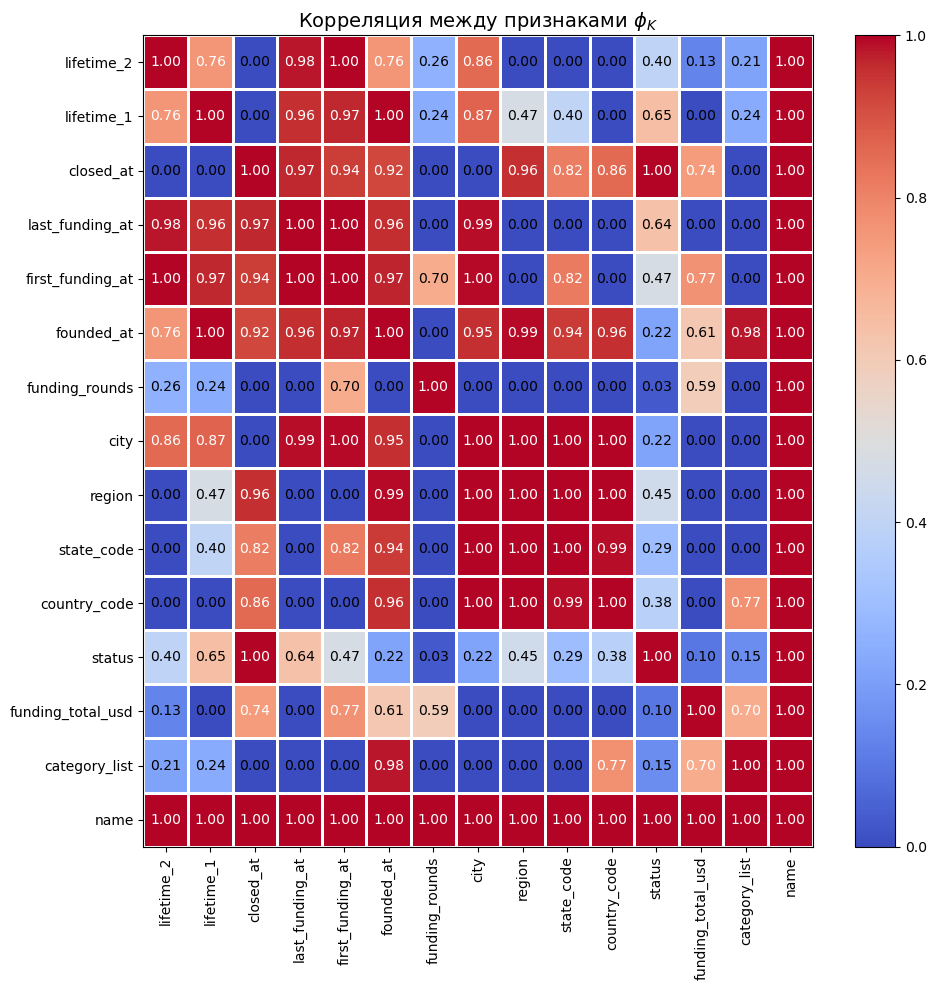

In [876]:
# список интервальных признаков
interval_cols = ['funding_total_usd', 'funding_rounds', 'lifetime_1', 'lifetime_2']

# вычисление 1000 коэффициентов корреляции phi для датафрейма df_train
phik_overview = df_train.sample(1000, random_state=RANDOM_STATE).phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    vmin=0, 
    vmax=1, 
    color_map='coolwarm', 
    title=r"Корреляция между признаками $\phi_K$", 
    fontsize_factor=1,                 
    figsize=(10,10)
)

**Вывод: Значение 'name' коррелирует со всеми значениями т.к имеет уникальные комбинации, т.е для каждого названия есть уникальное значение набора признаков. Такой коррелирующий признак не нужен при обучении модели. Умеренная взаимосвязь 'status' с 'lifetime_2', также умеренная взаимосвязь с датой основания и датой последней инвестиции, слабая с кодом страны, регионом и раундами инвестиций. Присутствует мультиколлинеарность между признаками местоположения, из этих признаков оставим один 'country_code'.
Для обучения моделей буду использовать след. входящие признаки:**
- 'category_list';
- 'country_code';
- 'lifetime_1';
- 'lifetime_2'.


### Пайплайн, обучение моделей, предсказания

In [906]:
# создаём датасет с отобранными признаками:
main_train = df_train[[
    'category_list',
    'country_code',
    'lifetime_1',
    'lifetime_2',
    'status'
]]

#разбиваем данные из датасета на тренировочную и тестовые выборки:
X_train, X_test, y_train, y_test = train_test_split(
    main_train.drop(['status'], axis=1),
    main_train['status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = main_train['status']
)

# кодируем значения целевого признака: 0 - 'closed'; 1 - 'operating':
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# формируем списки с названиями признаков:
ohe_columns = X_train.select_dtypes(include='object').columns.to_list()
num_columns = X_train.select_dtypes(include=np.number).columns.to_list()

# пайплайн для подготовки признаков из списка num_columns:
num_pipe = Pipeline(
    [
        (
            'imputer', 
            SimpleImputer(strategy='median')
        ),
        (
            'scaler', 
            MinMaxScaler()
        )
    ]
)

# создаем пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# общий пайплайн:
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, num_columns),
     ('ohe', ohe_pipe, ohe_columns)     
    ]
)

# итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# словари:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]


In [879]:
#поиск лучшей модели c перебором гиперпараметров:
randomized_model = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [880]:
randomized_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lifetime_1',
                                                                                'lifetime_2']),
                                                                              ('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_u...
                                         'models__max_depth': range(2, 10),
                                         'models__max_features': range(2, 10),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [881]:
#предсказания на тренировочной выборке:
y_train_pred = randomized_model.best_estimator_.fit(X_train, y_train).predict(X_train)
y_train_pred_prob = randomized_model.best_estimator_.predict_proba(X_train)[:,1]

In [882]:
print('1. Лучшая модель и её параметры:\n', randomized_model.best_estimator_)
print('\n')
print(f'2. Метрика ROC-AUC на тренировочной выборке: {round(roc_auc_score(y_train, y_train_pred_prob), 3)}')
print(f'3. Метрика F1 на тренировочной выборке: {round(f1_score(y_train, y_train_pred, average="macro"),3)}')

1. Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lifetime_1', 'lifetime_2']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                             

In [883]:
#предсказания на тестовой выборке:
y_test_pred = randomized_model.best_estimator_.predict(X_test)
y_test_pred_prob = randomized_model.best_estimator_.predict_proba(X_test)[:,1]

C:\Users\TOR\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\TOR\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [884]:
print(f'1. Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred_prob), 3)}')

print(f'2. Метрика F1 на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 3)}')

1. Метрика ROC-AUC на тестовой выборке: 0.938
2. Метрика F1 на тестовой выборке: 0.874


**Вывод: Лучшей моделью определилась логистическая регрессия. Выбрал ROC-AUC, потому-что данная метрика подходит для бинарной классификации с несбалансированной выборкой. F1-мера - это среднее гармоничное между precision и recall и значения находятся в диапозоне [0,1]. Результаты метрик стабильно хорошие: ROC-AUC на тренировочной выборке - 0.95, на тестовой выборке - 0.938; F1 на тренировочной выборке - 0.9, на тестовой выборке - 0.874**

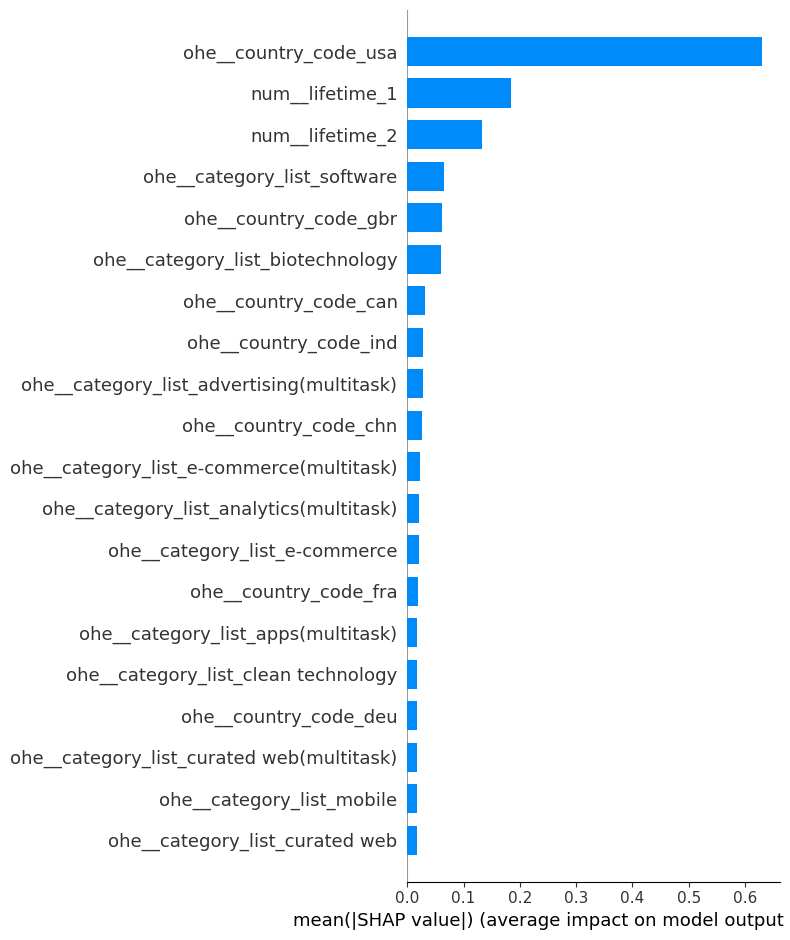

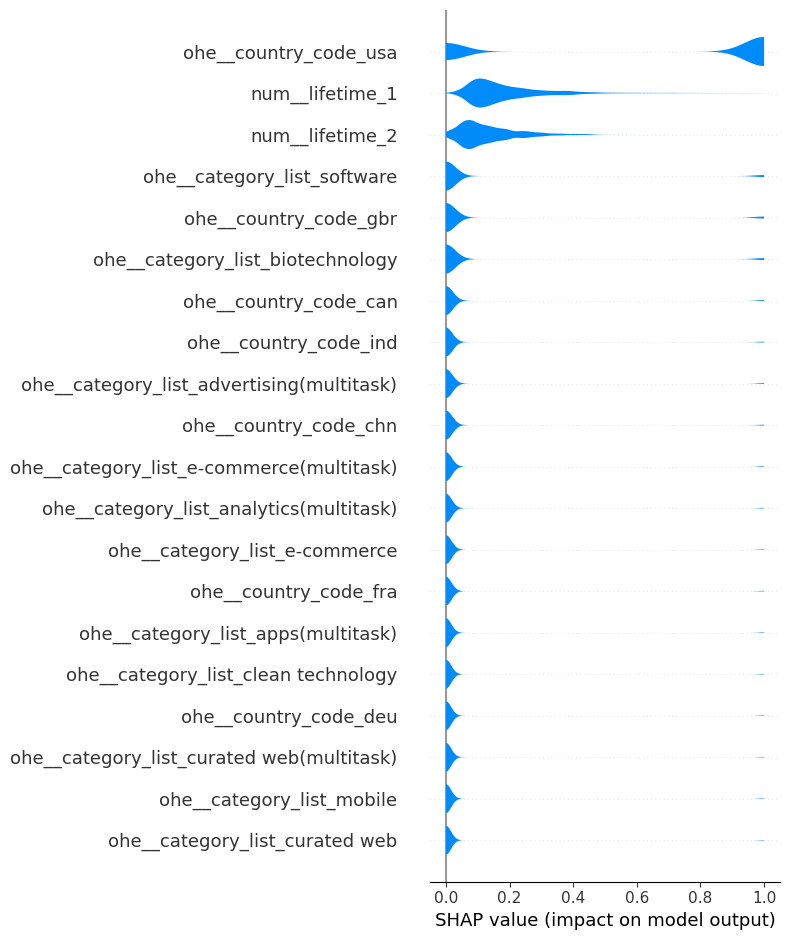

In [907]:
# Оценка важности признаков и  график важности с помощью метода SHAP
values = randomized_model.best_estimator_['preprocessor'].fit_transform(X_train)
best_model = randomized_model.best_estimator_['models'].fit(values, y_train)
explainer = shap.PermutationExplainer(best_model, values)
name = randomized_model.best_estimator_[: -1].get_feature_names_out()
 
shap.summary_plot(
    values, 
    plot_type='bar',
    feature_names=name, 
    plot_size='auto')

shap.summary_plot(
    values, 
    plot_type='violin', 
    feature_names=name, 
    plot_size='auto')

**Вывод: Категориальные признаки сильнее всего влияет на целевой показатель, но числовые признаки имеют значение.**

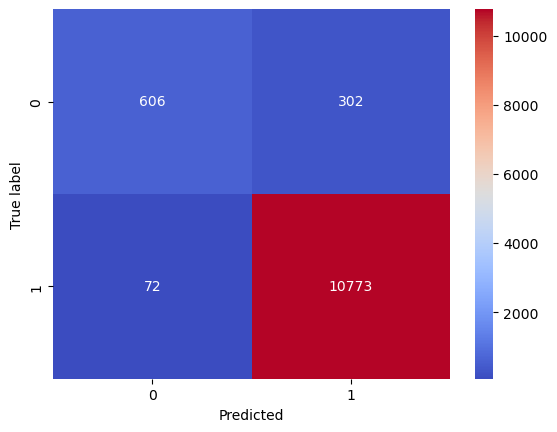

In [886]:
# матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [905]:
display(pd.DataFrame(data=label_encoder.classes_, columns=['status']))

,status
0,closed
1,operating


**Вывод: в 10773 случаях из 11742 успешность компании будет предсказана правильно т.е модель вполне эфективно даёт верные предсказания класса 1 .**

### Прогнозы

In [887]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11742 entries, 0 to 11741
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               11742 non-null  object        
 1   category_list      11742 non-null  object        
 2   funding_total_usd  11742 non-null  float64       
 3   country_code       11742 non-null  object        
 4   state_code         11742 non-null  object        
 5   region             11742 non-null  object        
 6   city               11742 non-null  object        
 7   funding_rounds     11742 non-null  int64         
 8   first_funding_at   11742 non-null  datetime64[ns]
 9   last_funding_at    11742 non-null  datetime64[ns]
 10  lifetime           11742 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1009.2+ KB


In [894]:
y_test_pred = pd.Series(y_test_pred)

main_test = df_test.reset_index()
main_test_submit = pd.concat([main_test['name'],y_test_pred], axis=1)
main_test_submit.columns = ['name','status']

<Axes: >

Количество дубликатов: 10


Количество удаленных дубликатов: None


Количество пропущенных значений:


name      2
status    0
dtype: int64

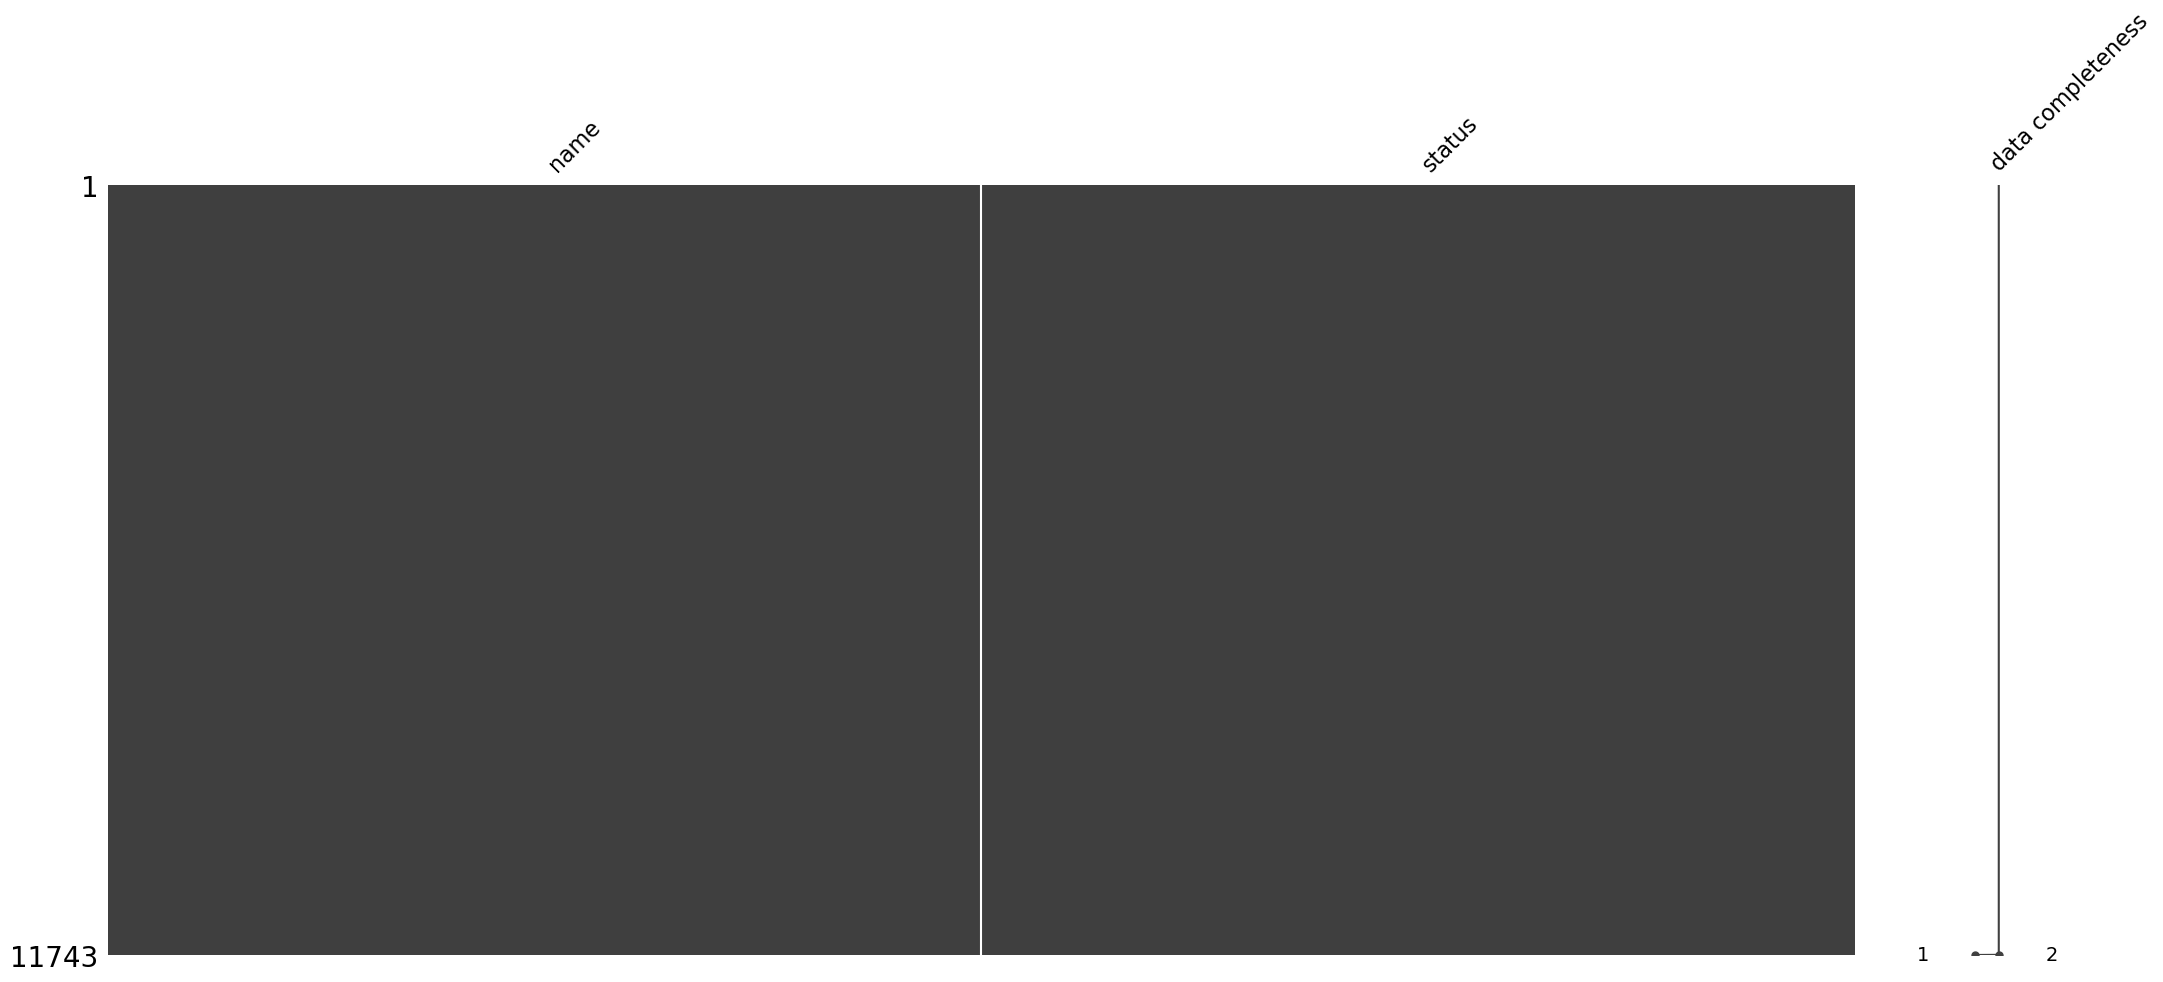

In [895]:
preprocessing(main_test_submit)

In [896]:
main_test_submit['status'] = main_test_submit['status'].apply(lambda _: 'operating' if _ == 1 else 'closed')
main_test_submit['status'].value_counts()

status
operating    11065
closed         678
Name: count, dtype: int64

In [898]:
main_test_submit.sample(15)

,name,status
5359,cloudbot,operating
3687,human genome research institutes,operating
8304,wave - private location app,operating
2111,greenwood hall,operating
9057,incentive,operating
5293,rfmicron,operating
2614,raintree oncology services,operating
6961,twtbks,operating
5303,knobias,closed
9900,12cm,operating


In [900]:
df_example_submit = pd.read_csv(
    'C:/Users/TOR/study/datasets/kaggle_startups_sample_submit_28062024.csv',
    sep = ',',
    decimal='.',
    converters={'category_list': lambda x: x.replace('|', ', ')}
)

In [901]:
df_example_submit.sample(15)

,name,status
1897,Axalent,closed
7006,Ojoo,operating
6007,Opera Solutions,closed
3666,Scroll.in,operating
1209,Breezeworks,closed
6591,Media360,operating
9228,TuVox,closed
12920,Pallet USA,closed
2767,Gigantt,closed
4497,Scalable Display Technologies,operating


### Общий вывод:

Для выполнения проекта были предоставлены 2 датасета в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы

**Изучение данных:** В ходе ознакомления с данными перед дальнейшими исследованиями были реализованы следующие шаги:
- Изучена  общая информация по 2-м датасетам: **df_train** с информацией (53 000) о стартапах, которые будут использоваться в качестве обучающих данных; **df_test** с информациtq (13 000) о стартапах, которые будут использоваться в качестве тестовых данных
- Выявлено, что информация в датасетах корректна, содержание соответствует наименованиям столбцов;
- Скорректирован дальнейший план действий по предобработке данных.

**Предобработка данных:**
- Значения в датасеты df_train и df_test приведены к нижнему регистру, выявлена высокая концентрацию пропущенных значений в столбцах funding_total_usd, country_code, state_code, region, city;
- Обнаружено 22106 уникальных комбинаций в тренировочном датасете, 6207 в тестовом. Из-за большой разницы, у компаний работающих в режиме многозадачности оставили первое наименование деятельности как главное, но с пометкой что присутствует мультизадачность;
- Ушли от большого разрыва по уникальным комбинациям деятельности между тренировочным и тестовым датасетами, что  улучшило обучение моделей и проверку на тестовых данных;
- Строки с пропущенными значениями одновременно по 4 стобцам 'country_code','state_code', 'region', 'city' были удалены. Восстановить код страны по региону, городу и коду штата также не получилось. Пропущенные строки в столбах 'state_code', 'region', 'city' заполнены значением 'no info'
- Раунды инвестиций представлены в диапозоне от 1 до 19 раундов;
- Большое кол-во пропусков в столбце 'closed_at' из-за того, что компании со статусом 'closed' имеют дату закрытия, а у компаний со статусом 'operating' такой даты нет, что превращается в пропущенное значение. По условию задания дата формирования выгрузки 2018-01-01 т.е пропущенные значения заменили на эту дату;
- После предобработки данных по датасету 'df_train' потеря данных составила 11,7%, но качество данных улучшилось т.к избавились от пропущенных значений. Это позволило улучшить качество обучения модели. Датасет достаточно объёмный (52516 значений на старте) оставшихся после предобработки данных (47013 значений) должно хватить для качественного обучения моделей;
- После предобработки данных по датасету  'df_test' потеря данных составила 11,7%, но качество данных улучшилось т.к избавились от пропущенных значений. Это позволило улучшшить качество тестовых данных. В датасете 'df_test' было 13125 значений на старте, после предобработки осталось 11743 значения которых должно хватить для качественного тестирования моделей.

**Исследовательский анализ данных:**
- По диаграмме размаха в стобце 'funding_total_usd' есть 1 сверхбольшое значение, но возможно оно соответствует действительности. Большинство стартапов привлекали относительно небольшие суммы инвестиций. Также можно сказать, что в основном стартапы проходили небольшое количество раундов инвестиций;
- За счёт удаления выбивающегося из основной массы значения, категориальные данные с тестовом датасете стали более однородными. У тестовой выборки практически такие же зависимости как у тренировочной, поялвляется новый признак, время существования компании;
- **Самые популярные категории деятельности компаний:**
    - Програмное обеспечение (17,4%);
    - Биотехнологии (16%).
- **Самые популярные страны по кол-ву стартапов:**
    - США - 70,7%;
    - Великобритания - 7%.
- **Соотношение закрытых и работающих компаний:**
    - 8% закрылись;
    - 92% продолжают работать.
- **Максимальное кол-во раундов инвестиций 19, но чаще всего 1**.

**Создание дополнительных (синтетических признаков):**
- **Для тренировочного датасета создали 2 новых признака на основе даты основания, даты закрытия, даты первого финансирования:**
    - 1 признак: продолжительность деятельности компании от основания до закрытия;
    - 2 признак: продолжительность деятельности компании от даты первой инвестиции до закрытия.

**Корреляция между признаками:**

Значение 'name' коррелирует со всеми значениями т.к имеет уникальные комбинации, т.е для каждого названия есть уникальное значение набора признаков. Такой коррелирующий признак не нужен при обучении модели. Умеренная взаимосвязь 'status' с 'lifetime_2', также умеренная взаимосвязь с датой основания и датой последней инвестиции, слабая с кодом страны, регионом и раундами инвестиций. Присутствует мультиколлинеарность между признаками местоположения, из этих признаков оставим один 'country_code'. Для обучения моделей буду использовать след. входящие признаки:
    **- 
'category_list'    - ;
'country_code    - ';
'lifetime_    - 1';
'lifetim**e_2'.

**Пайплайн, обучение моделей, предсказания:**
- Лучшей моделью определилась логистическая регрессия. Выбрал ROC-AUC, потому-что данная метрика подходит для бинарной классификации с несбалансированной выборкой. F1-мера - это среднее гармоничное между precision и recall и значения находятся в диапозоне [0,1]. Результаты метрик стабильно хорошие: ROC-AUC на тренировочной выборке - 0.95, на тестовой выборке - 0.938; F1 на тренировочной выборке - 0.9, на тестовой выборке - 0.874;
- Категориальные признаки сильнее всего влияет на целевой показатель, но числовые признаки имеют значение;
- в 10773 случаях из 11742 успешность компании будет предсказана правильно т.е модель вполне эфективно даёт верные предсказания класса 1.

**Итоговые рекомендации:**
- Наибольшее количество стартапов работает в сфере разработки програмного обеспечения, биотехнологий, онлайн-торговли и рекламы. Участие в данных сферах деятельности дают высокие шансы на успех;
- Значительная часть успешных стартапов находятся на территориях Северной Америки и Западной Европы. Думаю, это может говорить о наличии необходимой для развития инфраструктуры, и как следствие более высокого шанса на успех.